# Comparing Image Retrival with and without Generalizer

### Imports

In [34]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jeremias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jeremias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
image_path = "Images"
model_path = "image_caption_model_data"

### Load Image Captioning Model

#### Load Models and Tokenizer

In [164]:


model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



max_length = 30
num_beams = 5
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}
def predict_caption(image_paths):
  images = []
  for image_path in image_paths:
    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  return preds[0]

Some weights of the model checkpoint at nlpconnect/vit-gpt2-image-captioning were not used when initializing VisionEncoderDecoderModel: ['decoder.transformer.h.9.attn.bias', 'decoder.transformer.h.10.crossattention.bias', 'decoder.transformer.h.11.crossattention.masked_bias', 'decoder.transformer.h.1.attn.masked_bias', 'decoder.transformer.h.0.crossattention.masked_bias', 'decoder.transformer.h.11.attn.masked_bias', 'decoder.transformer.h.6.attn.masked_bias', 'decoder.transformer.h.3.attn.bias', 'decoder.transformer.h.5.attn.bias', 'decoder.transformer.h.5.crossattention.masked_bias', 'decoder.transformer.h.3.crossattention.bias', 'decoder.transformer.h.2.attn.bias', 'decoder.transformer.h.3.crossattention.masked_bias', 'decoder.transformer.h.10.attn.masked_bias', 'decoder.transformer.h.9.crossattention.bias', 'decoder.transformer.h.9.crossattention.masked_bias', 'decoder.transformer.h.0.crossattention.bias', 'decoder.transformer.h.8.attn.bias', 'decoder.transformer.h.1.crossattention.

'a little boy holding a yellow frisbee in his hand'

#### Generate Captions

In [37]:
images = os.listdir(image_path)

In [38]:
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())
    return ' '.join(list(set(synonyms)))


def generalize_query(caption):

    stop_words = set(stopwords.words('english'))

    words = [word.lower() for word in word_tokenize(caption) if word.lower() not in stop_words]

    generalized_texts = []

    for word in words:
        
        generated_text = get_synonyms(word)
        generalized_texts.append(generated_text)


    combined_text = ' '.join(generalized_texts)
    

    return combined_text

In [39]:
image_data = []

for image in images:
    caption = predict_caption([os.path.join(image_path,image)])
    generalized_caption = generalize_query(caption) 
    image_data.append((image, caption, generalized_caption))

image_data_df = pd.DataFrame(image_data, columns=['image','caption','generalized_caption'])

### Indexing Images

In [40]:
class Preprocessor:
    def __init__(self):
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.stemmer = PorterStemmer()

    def preprocess_string(self, data: str) -> list:
        # remove stopwords
        removed_stoppwords = []
        caption = data.lower()
        for word in caption.split():
            if word not in self.stopwords:
                removed_stoppwords.append(word)
        removed_stoppwords = " ".join(removed_stoppwords)

        # remove numbers and punctuation
        text_only = ""
        for character in removed_stoppwords:
            if character.isalpha() or character == " ":
                text_only += character
            else:
                text_only += " "

        # Tokenization
        tokenized = nltk.word_tokenize(text_only)

        # Stemming
        stemmed = [self.stemmer.stem(token) for token in tokenized]
        return stemmed

    def preprocess_dataset(self, df: pd.DataFrame) -> pd.DataFrame:
        df["tokens"] = df["caption"].astype(object)
        df["tokens_generalized"] = df["generalized_caption"].astype(object)
        for index, row in df.iterrows():
            df["tokens"][index] = self.preprocess_string(str(row["caption"]))
            df["tokens_generalized"][index] = self.preprocess_string(str(row["generalized_caption"]))
        return df
    
    def create_lookup_table(self, df: pd.DataFrame) -> dict[str,int]:
        all_tokens = df['tokens'].apply(pd.Series).stack().unique().tolist()
        all_tokens += df['tokens_generalized'].apply(pd.Series).stack().unique().tolist()
        all_tokens = set(all_tokens)
        lookup_table = {}
        i = 0
        for word in all_tokens:
            lookup_table[word] = i
            i+=1
        return lookup_table
    
    def create_reduced_document_index(self, df: pd.DataFrame, column: str, lookup_table: dict) -> list:
        document_counts = []
        for _, row in df.iterrows():
            binary_token_count = np.zeros(len(lookup_table))
            for token in row[column]:
                binary_token_count[lookup_table[token]] = 1
            document_counts.append((row["image"], binary_token_count))
        return document_counts

In [41]:
preprocessor = Preprocessor()
processed_df = preprocessor.preprocess_dataset(image_data_df)
lookup_table = preprocessor.create_lookup_table(processed_df)
searchable_images = preprocessor.create_reduced_document_index(processed_df,'tokens',lookup_table)
searchable_images_generalized = preprocessor.create_reduced_document_index(processed_df,'tokens_generalized',lookup_table)

### Searching

In [42]:
def search(lookup_table: dict, query_tokenized : list, documents: list) -> list:
    results = []
    compareable = np.zeros(len(lookup_table))
    for token in query_tokenized:
        if token in lookup_table:
            compareable[lookup_table[token]] = 1
    query_sum = np.sum(compareable.astype(int))

    if query_sum == 0:
        return []

    for document in documents:
        comparision = compareable.astype(bool) & document[1].astype(bool)
        comparison_sum = np.sum(comparision)
        if query_sum == comparison_sum:
            results.append(document[0])
    return results

In [43]:
def display_images(images):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(min(25,len(images))):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = load_img(f"Images/{images[i]}",color_mode='rgb',target_size=(224,224))
        image = img_to_array(image)
        image = image/255.
        plt.imshow(image)
        plt.axis("off")

<Figure size 2000x2000 with 0 Axes>

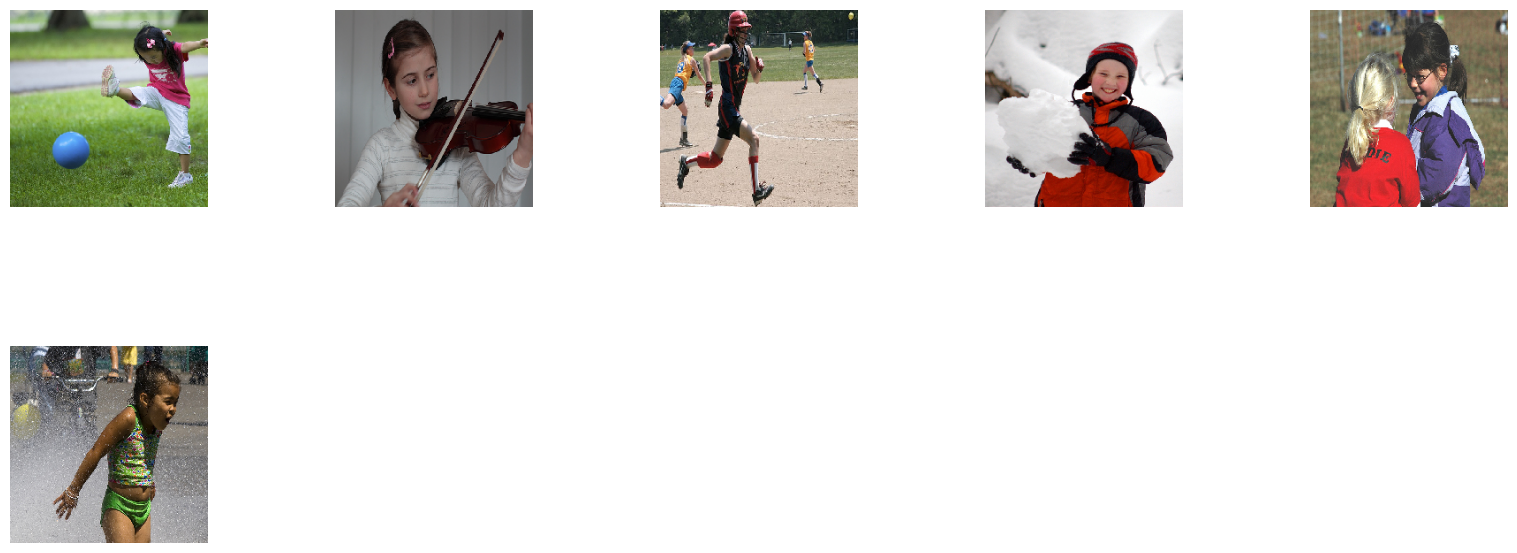

In [132]:
query = "a woman or girl playing the violin"
query_tokenized = preprocessor.preprocess_string(query)

results = search(lookup_table, query_tokenized, searchable_images)
results_generalized = search(lookup_table, query_tokenized, searchable_images_generalized)

display_images(results)
display_images(results_generalized)

### Results and plotting

In [186]:
queries = pd.read_csv("queries.csv")

dfs = []

for query in queries["Queries"]:
    query.strip()

    query_tokenized = preprocessor.preprocess_string(query)

    results = search(lookup_table, query_tokenized, searchable_images)
    results_generalized = search(lookup_table, query_tokenized, searchable_images_generalized)

    df_temp = pd.DataFrame({"Queries": [query], "results": [results], "results_generalized": [results_generalized]})

    dfs.append(df_temp)


query_df = pd.concat(dfs, ignore_index=True)

query_df.to_csv("results.csv")

    

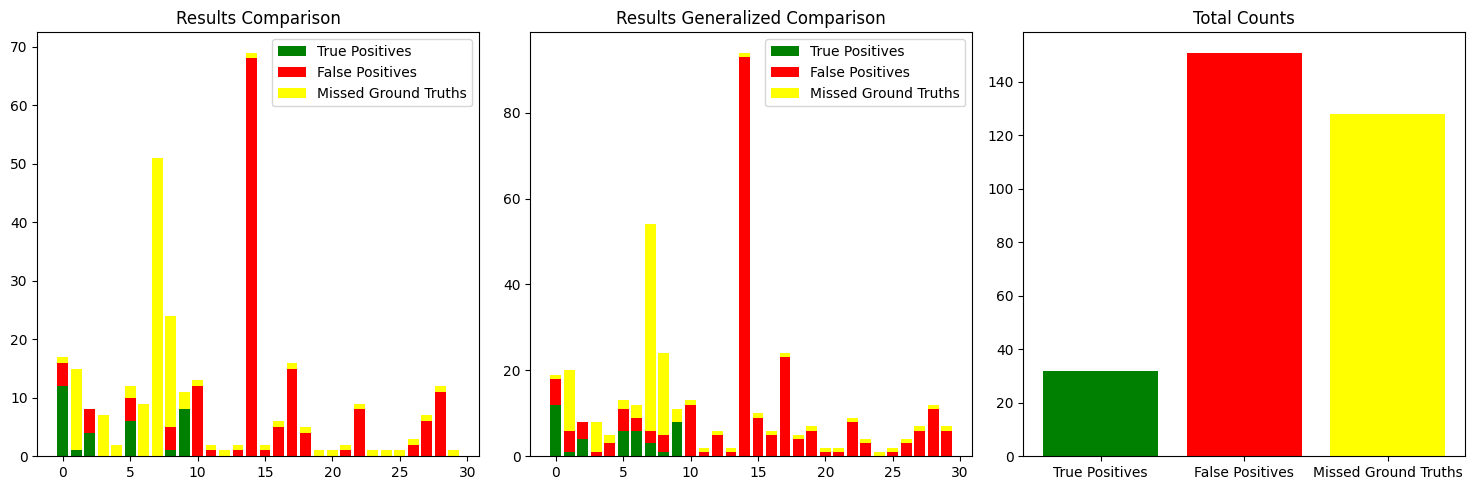

In [217]:
results_df = pd.read_csv('results.csv')
ground_truths_df = pd.read_csv('ground_truths.csv')

results_df['results'] = results_df['results'].apply(lambda x: [num.strip('.jpg') for num in eval(x)])
results_df['results_generalized'] = results_df['results_generalized'].apply(lambda x: [num.strip('.jpg') for num in eval(x)])

ground_truths_df['ground_truths'] = ground_truths_df['ground_truths'].astype(str)
ground_truths_df['ground_truths'] = ground_truths_df['ground_truths'].apply(lambda x: x.split())

results_df['ground_truths'] = ground_truths_df['ground_truths']


def calculate_metrics(row, column_name):
    results = set(row[column_name])
    ground_truths = set(row['ground_truths'])
    
    true_positives = len(results.intersection(ground_truths))
    false_positives = len(results - ground_truths)
    missed_ground_truths = len(ground_truths - results)
    
    
    return true_positives, false_positives, missed_ground_truths

# Calculate metrics for 'results' column
results_df['tp_results'], results_df['fp_results'], results_df['missed_results'] = zip(*results_df.apply(lambda row: calculate_metrics(row, 'results'), axis=1))

# Calculate metrics for 'results_generalized' column
results_df['tp_generalized'], results_df['fp_generalized'], results_df['missed_generalized'] = zip(*results_df.apply(lambda row: calculate_metrics(row, 'results_generalized'), axis=1))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].bar(results_df.index, results_df['tp_results'], color='green', label='True Positives')
ax[0].bar(results_df.index, results_df['fp_results'], bottom=results_df['tp_results'], color='red', label='False Positives')
ax[0].bar(results_df.index, results_df['missed_results'], bottom=results_df['tp_results']+results_df['fp_results'], color='yellow', label='Missed Ground Truths')
ax[0].set_title('Results Comparison')
ax[0].legend()

# Plot true positives, false positives, and missed ground truths for 'results_generalized' column
ax[1].bar(results_df.index, results_df['tp_generalized'], color='green', label='True Positives')
ax[1].bar(results_df.index, results_df['fp_generalized'], bottom=results_df['tp_generalized'], color='red', label='False Positives')
ax[1].bar(results_df.index, results_df['missed_generalized'], bottom=results_df['tp_generalized']+results_df['fp_generalized'], color='yellow', label='Missed Ground Truths')
ax[1].set_title('Results Generalized Comparison')
ax[1].legend()

# Plot the total counts for each category
ax[2].bar(['True Positives', 'False Positives', 'Missed Ground Truths'],
          [results_df['tp_results'].sum(), results_df['fp_results'].sum(), results_df['missed_results'].sum()],
          color=['green', 'red', 'yellow'])
ax[2].set_title('Total Counts')

plt.tight_layout()
plt.show()






